# **UCL Coefficient Predictor**
Collaborators: Archit Shankar, Iris Guo, Justenn Wang

---




## **Introduction**

Soccer, known as football in some parts of the world, is more than just a sport; it is a global phenomenon that unites millions of fans through its thrilling matches and historic tournaments. Among these tournaments, the UEFA Champions League stands out as one of the most prestigious and fiercely contested competitions. Predicting the winner of such a high-stakes event is not only a fascinating challenge but also one that has significant implications for fans, clubs, and the sports betting industry.

### Why is Predicting UEFA Champions League Coefficients Important?

Sports predictions, particularly for high-profile events like the UEFA Champions League, hold immense importance. Accurate predictions can influence betting markets, enhance fan engagement, and provide strategic insights for clubs and analysts. Beyond the excitement of guessing the winner, predicting outcomes in sports involves analyzing vast amounts of data and identifying patterns, which is a perfect application of data science.

In recent years, the use of machine learning in sports analytics has grown tremendously. By leveraging historical data and advanced algorithms, we can uncover the factors that contribute to a team's success and build models that predict future outcomes with impressive accuracy. This project will take you through the entire data science pipeline to create a machine learning model, specifically a decision tree, to predict UEFA Champions League winners.

### Objective
The main goal of this project is to develop a decision tree model to predict the winners of the UEFA Champions League. We will guide you through each step of the data science lifecycle, from data collection and preprocessing to exploratory data analysis (EDA), model training, and evaluation. By the end of this tutorial, you will have a comprehensive understanding of the processes involved in building a predictive model and the factors that influence the outcomes of football matches.

Over this tutorial we will be going through the Data Science Lifecycle

## **Data Collection**

We will collect data to eventually gain the following information about teams that we are looking at:

- All time club rankings

- Soccer power index rankings

- UEFA Coefficients over the past 5 years

- Net transfer spend over the past 5 years

- Net market value of players on a given team over the past 5 years



During this project, we will be using Python language, and we use tools such as Jupyter Notebook to develop this project. Heres some more information on how Jupyter notbook [works](https://jupyter.org/)

We will also need to import some libraries:

In [2]:
import os
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/4237753902.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


One of the main libraries that we will be using throughout this project is Pandas. [Pandas](https://shahsean.github.io/#https://pandas.pydata.org/) is an open-source data analysis tool that was built on top of the Python programming language and it is going to help us manipulate the data in an easy and flexible way. With the vast library of tools available, you can transform data very easily as you will see below.

Another library that helps maximize efficiency is [NumPy](https://shahsean.github.io/#https://numpy.org/). This library allows for easy computation for large datasets and it is another way to store and manipulate information.

We will also need to download Selenium and use webdrivers to scrape data. Run

In [5]:
#sudo pip3 install selenium

More information about selenium can be found on this link: https://www.selenium.dev/

Then import the following:

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

To get an idea of where we want to begin, we decided to look at the historic strength of teams in the Champions League. We were able to find a Kaggle dataset that contained all-time stats from teams in the champions league. This dataset can be found at the following link: https://www.kaggle.com/datasets/basharalkuwaiti/champions-league-era-stats

In [7]:
rank = pd.read_csv("AllTimeRankingByClub.csv", encoding='UTF-16')

rank.head(5)

,Position,Club,Country,Participated,Titles,Played,Win,Draw,Loss,Goals For,Goals Against,Pts,Goal Diff
0,1,Real Madrid CF,ESP,53,14,476,285,81,110,1047,521.0,651.0,526.0
1,2,FC Bayern München,GER,39,6,382,229,76,77,804,373.0,534.0,431.0
2,3,FC Barcelona,ESP,33,5,339,197,76,66,667,343.0,470.0,324.0
3,4,Manchester United,ENG,30,3,293,160,69,64,533,284.0,389.0,249.0
4,5,Juventus,ITA,37,2,301,153,70,78,479,301.0,376.0,178.0


Next, we decided to investigate the SPI of different clubs. SPI stands for Soccer Power Index, and is an indicator of club strength given by fivethirtyeight.com. The link can be found as follows: https://projects.fivethirtyeight.com/soccer-predictions/global-club-rankings/

We believe that global power rankings are a strong indicator of tournament success in the UCL, and thus decided to consider it in our model.

In [8]:
spi = pd.read_csv("spi_global_rankings.csv", encoding='UTF-8')

spi.head(5)

,rank,prev_rank,name,league,off,def,spi
0,1,1,Manchester City,Barclays Premier League,2.79,0.28,92.00
1,2,2,Bayern Munich,German Bundesliga,3.04,0.68,87.66
2,3,3,Barcelona,Spanish Primera Division,2.45,0.43,86.40
3,4,4,Real Madrid,Spanish Primera Division,2.56,0.60,84.41
4,5,5,Liverpool,Barclays Premier League,2.63,0.67,83.93


Next, we decided that the value of a team in the Champions League could be correlated to their success. Teams that are more wealthy and invest more into their players are more likely to have both better players, facilities, and coaches. Thus, we decided to find data that gave us the market worth of all players on a team. To do this, we decided to use transfermarkt, which is a reputable German soccer source that deals with events like transfer rumors. The official transfermarkt website is as follows: https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1

Because many things can change a soccer team even by the season, we decided to simply use the last 5 seasons for data regarding net market value of a team. In our model, more recent years are weighted the heaviest, while further back years are weighted lighter. The following code segments all serve to extract the net value of the players on different teams for the past 5 years, starting with the 2023-2024 season.

In [9]:
#This is the data for 2023-2024 Season

# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/uefa-champions-league/teilnehmer/pokalwettbewerb/CL/saison_id/2023'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)
twentythree = pd.concat(table)
twentythree.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/4165066953.py:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value
0,Filter by season:,23/2423/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,Real Madrid,24.0,27.3,€1.04bn,€43.21m,NaN
1,NaN,NaN,NaN,NaN,Borussia Dortmund,29.0,25.5,€463.70m,€15.99m,NaN
0,NaN,NaN,NaN,NaN,Manchester City,22.0,26.9,€1.27bn,€57.74m,NaN
1,NaN,NaN,NaN,NaN,Arsenal FC,25.0,25.7,€1.12bn,€44.74m,NaN
2,NaN,NaN,NaN,NaN,Paris Saint-Germain,30.0,25.4,€1.02bn,€33.99m,NaN
3,NaN,NaN,NaN,NaN,Bayern Munich,27.0,26.8,€929.45m,€34.42m,NaN
4,NaN,NaN,NaN,NaN,FC Barcelona,26.0,25.1,€839.50m,€32.29m,NaN
5,NaN,NaN,NaN,NaN,Manchester United,26.0,26.8,€730.25m,€28.09m,NaN
6,NaN,NaN,NaN,NaN,Newcastle United,28.0,27.6,€637.70m,€22.78m,NaN


The following code extracts the net value of players for different teams for the 2022-2023 season.

In [10]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/uefa-champions-league/teilnehmer/pokalwettbewerb/CL/saison_id/2022'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)
twentytwo = pd.concat(table)
twentytwo.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/2543189557.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value
0,Filter by season:,22/2323/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,Manchester City,22.0,25.5,€1.27bn,€57.74m,NaN
1,NaN,NaN,NaN,NaN,Real Madrid,24.0,25.4,€1.04bn,€43.21m,NaN
2,NaN,NaN,NaN,NaN,Paris Saint-Germain,30.0,25.5,€1.02bn,€33.99m,NaN
3,NaN,NaN,NaN,NaN,Bayern Munich,27.0,25.3,€929.45m,€34.42m,NaN
4,NaN,NaN,NaN,NaN,Chelsea FC,30.0,24.7,€928.30m,€30.94m,NaN
5,NaN,NaN,NaN,NaN,Liverpool FC,28.0,25.1,€921.40m,€32.91m,NaN
6,NaN,NaN,NaN,NaN,FC Barcelona,26.0,24.0,€839.50m,€32.29m,NaN
7,NaN,NaN,NaN,NaN,Tottenham Hotspur,26.0,25.4,€777.30m,€29.90m,NaN
8,NaN,NaN,NaN,NaN,Inter Milan,25.0,26.4,€622.35m,€24.89m,NaN


The following code extracts the net value of players for different teams for the 2021-2022 season.

In [11]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/uefa-champions-league/teilnehmer/pokalwettbewerb/CL/saison_id/2021'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)
twentyone = pd.concat(table)
twentyone.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/1316040077.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value
0,Filter by season:,21/2223/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,Manchester City,22.0,24.3,€1.27bn,€57.74m,NaN
1,NaN,NaN,NaN,NaN,Real Madrid,24.0,25.7,€1.04bn,€43.21m,NaN
2,NaN,NaN,NaN,NaN,Paris Saint-Germain,30.0,25.7,€1.02bn,€33.99m,NaN
3,NaN,NaN,NaN,NaN,Bayern Munich,27.0,24.7,€929.45m,€34.42m,NaN
4,NaN,NaN,NaN,NaN,Chelsea FC,30.0,25.1,€928.30m,€30.94m,NaN
5,NaN,NaN,NaN,NaN,Liverpool FC,28.0,24.0,€921.40m,€32.91m,NaN
6,NaN,NaN,NaN,NaN,FC Barcelona,26.0,25.1,€839.50m,€32.29m,NaN
7,NaN,NaN,NaN,NaN,Manchester United,26.0,25.5,€730.25m,€28.09m,NaN
8,NaN,NaN,NaN,NaN,Inter Milan,25.0,27.2,€622.35m,€24.89m,NaN


The following code extracts the net value of players for different teams for the 2020-2021 season.

In [12]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/uefa-champions-league/teilnehmer/pokalwettbewerb/CL/saison_id/2020'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)
twenty = pd.concat(table)
twenty.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/1042087757.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value
0,Filter by season:,20/2123/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,Manchester City,22.0,24.9,€1.27bn,€57.74m,NaN
1,NaN,NaN,NaN,NaN,Real Madrid,24.0,24.8,€1.04bn,€43.21m,NaN
2,NaN,NaN,NaN,NaN,Paris Saint-Germain,30.0,24.2,€1.02bn,€33.99m,NaN
3,NaN,NaN,NaN,NaN,Bayern Munich,27.0,23.9,€929.45m,€34.42m,NaN
4,NaN,NaN,NaN,NaN,Chelsea FC,30.0,25.2,€928.30m,€30.94m,NaN
5,NaN,NaN,NaN,NaN,Liverpool FC,28.0,24.4,€921.40m,€32.91m,NaN
6,NaN,NaN,NaN,NaN,FC Barcelona,26.0,25.1,€839.50m,€32.29m,NaN
7,NaN,NaN,NaN,NaN,Manchester United,26.0,24.9,€730.25m,€28.09m,NaN
8,NaN,NaN,NaN,NaN,Inter Milan,25.0,25.2,€622.35m,€24.89m,NaN


The following code extracts the net value of players for different teams for the 2019-2020 season.

In [13]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/uefa-champions-league/teilnehmer/pokalwettbewerb/CL/saison_id/2019'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nineteen = pd.concat(table)
nineteen.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/2004943268.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value
0,Filter by season:,19/2023/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,Manchester City,22.0,25.1,€1.27bn,€57.74m,NaN
1,NaN,NaN,NaN,NaN,Real Madrid,24.0,25.6,€1.04bn,€43.21m,NaN
2,NaN,NaN,NaN,NaN,Paris Saint-Germain,30.0,25.2,€1.02bn,€33.99m,NaN
3,NaN,NaN,NaN,NaN,Bayern Munich,27.0,23.7,€929.45m,€34.42m,NaN
4,NaN,NaN,NaN,NaN,Chelsea FC,30.0,24.1,€928.30m,€30.94m,NaN
5,NaN,NaN,NaN,NaN,Liverpool FC,28.0,23.3,€921.40m,€32.91m,NaN
6,NaN,NaN,NaN,NaN,FC Barcelona,26.0,24.2,€839.50m,€32.29m,NaN
7,NaN,NaN,NaN,NaN,Tottenham Hotspur,26.0,24.8,€777.30m,€29.90m,NaN
8,NaN,NaN,NaN,NaN,Inter Milan,25.0,26.7,€622.35m,€24.89m,NaN


Next, we decided to look at net transfer spend. While the overall market value of players on a team is an indicator of the team strength, the net transfer spend is also an indicator that gives more insight into the yearly outcome of a soccer club. For example, a team that spends more on transfer arrivals is more likely to have a better club, while a team that loses many players on transfer departures might see their level fall. Again, we are using the transfermarkt website to retrieve this data, and similarly, we will be collecting this data for teams from the past 5 years.

The following code extracts the net market spend for different teams for the 2023-2024 season.

In [14]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2023&saison_id_bis=2023&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts23 = table[1]
nts23.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/2103040352.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Chelsea FC,€467.80m,29,€269.50m,31,€-198.30m,NaN
1,2,NaN,Paris Saint-Germain,€454.50m,33,€207.50m,31,€-247.00m,NaN
2,3,NaN,Al-Hilal SFC,€376.10m,19,€1.38m,22,€-374.72m,NaN
3,4,NaN,Tottenham Hotspur,€272.10m,27,€120.70m,22,€-151.40m,NaN
4,5,NaN,Manchester City,€259.60m,17,€125.80m,20,€-133.80m,NaN
5,6,NaN,Arsenal FC,€234.94m,15,€69.20m,16,€-165.74m,NaN
6,7,NaN,Manchester United,€202.30m,15,€58.34m,24,€-143.96m,NaN
7,8,NaN,Bayern Munich,€187.50m,16,€173.25m,17,€-14.25m,NaN
8,9,NaN,Al-Ahli SFC,€184.10m,28,€1.74m,30,€-182.35m,NaN
9,10,NaN,RB Leipzig,€179.50m,24,€243.70m,27,€64.20m,NaN


The following code extracts the net market spend for different teams for the 2022-2023 season.

In [15]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2022&saison_id_bis=2022&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts22 = table[1]
nts22.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/21753371.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Chelsea FC,€630.35m,26,€67.86m,24,€-562.49m,NaN
1,2,NaN,Manchester United,€243.28m,24,€23.65m,19,€-219.63m,NaN
2,3,NaN,Nottingham Forest,€194.55m,42,€5.00m,26,€-189.55m,NaN
3,4,NaN,West Ham United,€186.60m,12,€21.55m,13,€-165.05m,NaN
4,5,NaN,Arsenal FC,€186.40m,25,€23.80m,18,€-162.60m,NaN
5,6,NaN,Newcastle United,€185.35m,17,€14.06m,13,€-171.29m,NaN
6,7,NaN,Tottenham Hotspur,€179.90m,15,€38.75m,14,€-141.15m,NaN
7,8,NaN,Wolverhampton Wanderers,€177.11m,32,€62.87m,28,€-114.24m,NaN
8,9,NaN,FC Barcelona,€158.00m,16,€39.50m,22,€-118.50m,NaN
9,10,NaN,Leeds United,€157.39m,25,€114.50m,19,€-42.89m,NaN


The following code extracts the net market spend for different teams for the 2021-2022 season.

In [16]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2021&saison_id_bis=2021&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts21 = table[1]
nts21.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/2872304125.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Arsenal FC,€167.40m,13,€31.40m,20,€-136.00m,NaN
1,2,NaN,Manchester United,€142.00m,16,€31.10m,14,€-110.90m,NaN
2,3,NaN,Juventus FC,€141.65m,20,€64.03m,18,€-77.62m,NaN
3,4,NaN,Manchester City,€138.90m,21,€93.80m,24,€-45.10m,NaN
4,5,NaN,AS Roma,€132.05m,38,€17.24m,39,€-114.82m,NaN
5,6,NaN,Newcastle United,€130.50m,12,-,10,€-130.50m,NaN
6,7,NaN,Aston Villa,€129.80m,22,€127.00m,18,€-2.80m,NaN
7,8,NaN,RB Leipzig,€125.62m,18,€113.50m,20,€-12.12m,NaN
8,9,NaN,Chelsea FC,€118.00m,21,€154.69m,23,€36.69m,NaN
9,10,NaN,AC Milan,€100.36m,28,€5.12m,27,€-95.24m,NaN


The following code extracts the net market spend for different teams for the 2020-2021 season.

In [17]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2020&saison_id_bis=2020&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts20 = table[1]
nts20.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/2361568598.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Chelsea FC,€247.20m,31,€57.15m,26,€-190.05m,NaN
1,2,NaN,Manchester City,€173.40m,28,€64.00m,27,€-109.40m,NaN
2,3,NaN,Juventus FC,€162.81m,20,€110.31m,20,€-52.50m,NaN
3,4,NaN,Leeds United,€127.80m,16,-,17,€-127.80m,NaN
4,5,NaN,Inter Milan,€126.50m,35,€82.95m,41,€-43.55m,NaN
5,6,NaN,SL Benfica,€115.00m,28,€81.72m,27,€-33.28m,NaN
6,7,NaN,FC Barcelona,€111.94m,18,€154.40m,15,€42.46m,NaN
7,8,NaN,Tottenham Hotspur,€110.50m,15,€13.30m,11,€-97.20m,NaN
8,9,NaN,Parma Calcio 1913,€102.33m,58,€4.00m,51,€-98.33m,NaN
9,10,NaN,Aston Villa,€101.35m,12,€2.77m,15,€-98.58m,NaN


The following code extracts the net market spend for different teams for the 2019-2020 season.

In [18]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2019&saison_id_bis=2019&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts19 = table[1]
nts19.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/3106206303.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Real Madrid,€361.30m,23,€136.80m,22,€-224.50m,NaN
1,2,NaN,FC Barcelona,€303.00m,22,€154.40m,23,€-148.60m,NaN
2,3,NaN,Atlético de Madrid,€247.35m,20,€316.30m,19,€68.95m,NaN
3,4,NaN,Manchester United,€236.80m,13,€81.18m,12,€-155.62m,NaN
4,5,NaN,Juventus FC,€235.30m,23,€203.14m,24,€-32.16m,NaN
5,6,NaN,SSC Napoli,€210.02m,47,€48.72m,43,€-161.30m,NaN
6,7,NaN,AS Monaco,€200.00m,33,€83.75m,39,€-116.25m,NaN
7,8,NaN,Inter Milan,€192.02m,51,€66.74m,48,€-125.28m,NaN
8,9,NaN,Sevilla FC,€188.73m,30,€131.40m,33,€-57.33m,NaN
9,10,NaN,Manchester City,€169.82m,25,€71.00m,26,€-98.82m,NaN


The following code extracts the net market spend for different teams for the 2018-2019 season.

In [19]:
# URL of the webpage to scrape
url = 'https://www.transfermarkt.us/transfers/einnahmenausgaben/statistik/plus/0?ids=a&sa=&saison_id=2018&saison_id_bis=2018&land_id=&nat=&kontinent_id=&pos=&altersklasse=&w_s=&leihe=&intern=0&plus=0'

# Set up the WebDriver (ensure the path to the chromedriver is correct)
driver = webdriver.Chrome()

# Open the URL
driver.get(url)

# Get the page source after JavaScript has rendered
html = driver.page_source

# Parse the HTML content using BeautifulSoup
soup = bs(html, 'html.parser')
table = pd.read_html(html)

nts18 = table[1]
nts18.head(10)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/1999395064.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(html)


,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance
0,1,NaN,Juventus FC,€265.30m,41,€112.54m,35,€-152.76m,NaN
1,2,NaN,Paris Saint-Germain,€262.00m,21,€114.00m,18,€-148.00m,NaN
2,3,NaN,Chelsea FC,€208.80m,30,€83.25m,31,€-125.55m,NaN
3,4,NaN,AC Milan,€194.64m,26,€88.10m,28,€-106.54m,NaN
4,5,NaN,Liverpool FC,€182.20m,18,€41.32m,21,€-140.88m,NaN
5,6,NaN,Atlético de Madrid,€168.00m,22,€57.90m,19,€-110.10m,NaN
6,7,NaN,AS Roma,€166.35m,45,€150.47m,46,€-15.88m,NaN
7,8,NaN,Real Madrid,€164.75m,16,€136.10m,14,€-28.65m,NaN
8,9,NaN,AS Monaco,€145.85m,37,€367.25m,29,€221.40m,NaN
9,10,NaN,FC Barcelona,€141.10m,19,€146.05m,19,€4.95m,NaN


Now, we are going to gather Uefa club coefficient rankings. These rankings come from UEFA themselves, and rank European teams based on their performance over the past years. This coefficient also determines seeding in the tournament's draws. Because these rankings are essentially a model that determine team strength, we think it is a strong indicator of those teams' performance in the Champions League. To find the table shown below, go to https://en.wikipedia.org/wiki/UEFA_coefficient#Men's_club_coefficient and scroll down to the "Current Club Ranking" header. The table below is the table under that header.

In [20]:
url = 'https://en.wikipedia.org/wiki/UEFA_coefficient#Men\'s_club_coefficient'
response = requests.get(url)

soup = bs(response.content, "html.parser")

tables = soup.find_all('table')

selected_table = tables[9]

uefa = pd.read_html(str(selected_table))[0]
uefa.head(5)

/var/folders/3v/cd_7z9c16rl8tw6ng6t03vyw0000gn/T/ipykernel_68986/1354231701.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  uefa = pd.read_html(str(selected_table))[0]


Ranking                           Club Association Coefficient          \
     2024 2023 Mvmt                 Club Association     2019–20 2020–21   
0       1    1    –      Manchester City     England        25.0    35.0   
1       2    2    –        Bayern Munich     Germany        36.0    27.0   
2       3    5   +2          Real Madrid       Spain        17.0    26.0   
3       4    6   +2  Paris Saint-Germain      France        31.0    24.0   
4       5    4   –1            Liverpool     England        18.0    24.0   

                                  
  2021–22 2022–23 2023–24  Total  
0    27.0    33.0    28.0  148.0  
1    26.0    27.0    28.0  144.0  
2    30.0    29.0    32.0  134.0  
3    19.0    19.0    23.0  116.0  
4    33.0    19.0    20.0  114.0

Next, we found the results of all matches that occurred in the Champions League from 2016 - 2022. Since we are specifically investigating from 2018 onward, we decided to filter out all matches that occurred before that point. The reason why we are interested in the outcome of different matches is so we can determine where each team finished at the end of the UCL tournament. The dataset used can be found at the following link: https://www.kaggle.com/datasets/mikolajhojda/uefa-champions-league-20152016-20212022

In [21]:
matches = pd.read_csv("matches.csv", encoding='UTF-8')

# Convert the 'datetime' column to datetime format
matches['datetime'] = pd.to_datetime(matches['datetime'])

# Define the cutoff date for filtering
cutoff_date = pd.Timestamp('2018-07-01 00:00:00+00:00')

# Filter the DataFrame to include only matches from the cutoff date onwards
filtered_matches = matches[matches['datetime'] >= cutoff_date]

filtered_matches

,Unnamed: 0,datetime,team1,team2,team1_code,team2_code,round,score1,score2,adj_score1,adj_score2,chances1,chances2,moves1,moves2,group,matchday
250,250,2018-09-18 16:55:00+00:00,Internazionale,Tottenham Hotspur,INT,TOT,g,2,1,2.100,1.05,1.400,0.882,1.722,0.899,B,NaN
251,251,2018-09-18 16:55:00+00:00,Barcelona,PSV,BAR,PSV,g,4,0,3.483,0.00,2.034,0.669,2.524,0.400,B,NaN
252,252,2018-09-18 19:00:00+00:00,Club Brugge,Borussia Dortmund,CBKV,DOR,g,0,1,0.000,1.05,0.511,0.946,0.833,1.726,A,NaN
253,253,2018-09-18 19:00:00+00:00,Liverpool,Paris Saint-Germain,LIV,PSG,g,3,2,3.150,2.10,2.377,1.201,1.927,0.711,C,NaN
254,254,2018-09-18 19:00:00+00:00,Schalke 04,FC Porto,SCH,POR,g,1,1,1.050,1.05,0.886,2.374,0.906,0.886,D,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,739,2022-04-26 19:00:00+00:00,Manchester City,Real Madrid,MNC,MAD,s,4,3,4.200,3.15,3.307,1.620,1.739,0.980,NaN,NaN
740,740,2022-04-27 19:00:00+00:00,Liverpool,Villarreal,LIV,VLR,s,2,0,2.100,0.00,1.843,0.090,2.481,0.186,NaN,NaN
741,741,2022-05-03 19:00:00+00:00,Villarreal,Liverpool,VLR,LIV,s,2,3,2.100,3.15,1.478,1.587,0.860,1.607,NaN,NaN
742,742,2022-05-04 19:00:00+00:00,Real Madrid,Manchester City,MAD,MNC,s,3,1,3.150,1.05,2.602,1.731,2.397,1.841,NaN,NaN


Building off of our intentions with the matches dataset, we then create a dataframe to list out the teams that played in each year's UCL knockout stage and the furthest they got. The code below creates that dataframe.

In [22]:
knockout_rounds = ['Round of 16', 'Quarter-finals', 'Semi-finals', 'Final']
matches = matches[matches['round'].isin(knockout_rounds)]

# Create a dictionary to specify the order of rounds
round_order = {
    'k': 'ro16 reached',
    'q': 'qf reached',
    's': 'sf reached',
    'f': 'final reached'
}

# Create a list to store the results
results = []

# Iterate over each year
for year in range(2019, 2023):
    # Filter matches for the current season
    season_start = pd.Timestamp(f'{year - 1}-07-01 00:00:00+00:00')
    season_end = pd.Timestamp(f'{year}-06-30 00:00:00+00:00')
    season_matches = filtered_matches[(filtered_matches['datetime'] >= season_start) & (filtered_matches['datetime'] <= season_end)]

    teams = set(season_matches['team1']).union(set(season_matches['team2']))

    for team in teams:
        team_data = {'team': team, 'year': year, 'ro16 reached': 0, 'qf reached': 0, 'sf reached': 0, 'final reached': 0, 'final won': 0}

        # Check if the team reached each round
        for round_name, column_name in round_order.items():
            if any((season_matches['team1'] == team) & (season_matches['round'] == round_name)) or \
               any((season_matches['team2'] == team) & (season_matches['round'] == round_name)):
                team_data[column_name] = 1

        # Check if the team won the final
        if any((season_matches['team1'] == team) & (season_matches['round'] == 'f') & (season_matches['score1'] > season_matches['score2'])) or \
           any((season_matches['team2'] == team) & (season_matches['round'] == 'f') & (season_matches['score2'] > season_matches['score1'])):
            team_data['final won'] = 1

        # Append the team's data to the results list
        results.append(team_data)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the final DataFrame
results_df

,team,year,ro16 reached,qf reached,sf reached,final reached,final won
0,Borussia Dortmund,2019,1,0,0,0,0
1,Benfica,2019,0,0,0,0,0
2,AS Roma,2019,1,0,0,0,0
3,Ajax,2019,1,1,1,0,0
4,Internazionale,2019,0,0,0,0,0
...,...,...,...,...,...,...,...
125,Liverpool,2022,1,1,1,1,0
126,Atalanta,2022,0,0,0,0,0
127,Bayern Munich,2022,1,1,0,0,0
128,Juventus,2022,1,0,0,0,0


Here, we filter out teams that have never reached the knockout stage of a UCL. We think that because these teams have never reached the knockout stage, and we are specifically predicting the results of the knockout stage, teams that have never reached the knockout stage are likely to not provide much information about winning chances in the knockout stage.

In [23]:
filtered_results_df = results_df[results_df['ro16 reached'] == 1]
filtered_results_df

,team,year,ro16 reached,qf reached,sf reached,final reached,final won
0,Borussia Dortmund,2019,1,0,0,0,0
2,AS Roma,2019,1,0,0,0,0
3,Ajax,2019,1,1,1,0,0
8,Manchester City,2019,1,1,0,0,0
11,Real Madrid,2019,1,0,0,0,0
...,...,...,...,...,...,...,...
124,Lille,2022,1,0,0,0,0
125,Liverpool,2022,1,1,1,1,0
127,Bayern Munich,2022,1,1,0,0,0
128,Juventus,2022,1,0,0,0,0


## **Data Processing**

1. Put data in Dataframe
2. Remove Unecessary Columns
3. Do any Data Filtering we need to do
4. Do any Formatting we need to, like dates, years, etc
5. Do any other data modifying or merging needed

Before you start the data analysis, choose how you want to modify the cleaned data for certain problems and Handle Missing Data


### Putting Net Value Data into one DataFrame and filtering

We have 5 different tables for all of the Net Values of teams from different years, but we want to put it all into one table for further analysis.

In [24]:
# Add a year label to each of the datasets
twentythree['Year'] = "2023"
twentytwo['Year'] = "2022"
twentyone['Year'] = "2021"
twenty['Year'] = "2020"
nineteen['Year'] = "2019"

# List of DataFrames to concatenate
pds = [twentythree, twentytwo, twentyone, twenty, nineteen]
net_vals = pd.concat(pds, ignore_index=True)

net_vals.head(5)

,0,1,2,wappen,Club,Club.1,Squad,ø-Age,Market Value,ø-Market Value,Year
0,Filter by season:,23/2423/2422/2321/2220/2119/2018/1917/1816/171...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,NaN,NaN,NaN,NaN,Real Madrid,24.0,27.3,€1.04bn,€43.21m,NaN,2023
2,NaN,NaN,NaN,NaN,Borussia Dortmund,29.0,25.5,€463.70m,€15.99m,NaN,2023
3,NaN,NaN,NaN,NaN,Manchester City,22.0,26.9,€1.27bn,€57.74m,NaN,2023
4,NaN,NaN,NaN,NaN,Arsenal FC,25.0,25.7,€1.12bn,€44.74m,NaN,2023


Now we are going to do some filtering. We will start by dropping columns that don't have data useful to us.

In [25]:
net_vals = net_vals.drop(net_vals.columns[[0, 1, 2, 4, 5, 6, 7, 9]], axis=1)
net_vals.rename(columns={'ø-Age': 'Market Value', 'Club.1' : 'Squad Size'}, inplace=True)
net_vals = net_vals.drop(0)

net_vals.head(5)

,wappen,Market Value,Year
1,NaN,€43.21m,2023
2,NaN,€15.99m,2023
3,NaN,€57.74m,2023
4,NaN,€44.74m,2023
5,NaN,€33.99m,2023


Now convert these market values to a numerical value. We also normalize the data for market value. Normalizing the data simply means that we are organizing the data in such a manner that will benefit our models and improve the consistency of our data. This will eventually put our Market Value values onto a scale from 0-1, which will make our data much easier to visualize and compare.

In [27]:
def clean_currency(column):
    return column.str.replace('€', '').str.replace('m', '0000').str.replace('bn', '0000000').str.replace('.', '').str.replace('k', '000').astype(float)

net_vals['Market Value'] = clean_currency(net_vals['Market Value'])

#Normalize the data
scaler = MinMaxScaler()

net_vals['Market Value Normalized'] = scaler.fit_transform(net_vals[['Market Value']])

#Drop our market value column
net_vals.drop(columns = ['Market Value'], inplace = True)

net_vals.head(5)

,wappen,Year,Market Value Normalized
1,NaN,2023,0.746939
2,NaN,2023,0.272863
3,NaN,2023,1.000000
4,NaN,2023,0.773586
5,NaN,2023,0.586359


Now we are going to look at our Net Tranfer Values from different years, and collapse them into a single table for analysis.

In [28]:
# Add a year label to each of the datasets
nts23['Year'] = "2023"
nts22['Year'] = "2022"
nts21['Year'] = "2021"
nts20['Year'] = "2020"
nts19['Year'] = "2019"

# List of DataFrames to concatenate
pds = [nts23, nts22, nts21, nts20, nts19]
net_transfer_vals = pd.concat(pds, ignore_index=True)

net_transfer_vals.head(5)

,#,Club,Club.1,Club.2,Expenditure,Arrivals,Income,Departures,Balance,Year
0,1,NaN,Chelsea FC,€467.80m,29,€269.50m,31,€-198.30m,NaN,2023
1,2,NaN,Paris Saint-Germain,€454.50m,33,€207.50m,31,€-247.00m,NaN,2023
2,3,NaN,Al-Hilal SFC,€376.10m,19,€1.38m,22,€-374.72m,NaN,2023
3,4,NaN,Tottenham Hotspur,€272.10m,27,€120.70m,22,€-151.40m,NaN,2023
4,5,NaN,Manchester City,€259.60m,17,€125.80m,20,€-133.80m,NaN,2023


Here, we are going to drop some unnecessary columns so our data is more readable

In [29]:
net_transfer_vals = net_transfer_vals.drop(net_transfer_vals.columns[[0, 1, 4, 5, 6, 7, 8]], axis=1)

net_transfer_vals.head(5)

,Club.1,Club.2,Year
0,Chelsea FC,€467.80m,2023
1,Paris Saint-Germain,€454.50m,2023
2,Al-Hilal SFC,€376.10m,2023
3,Tottenham Hotspur,€272.10m,2023
4,Manchester City,€259.60m,2023


Here, we rename the columns to get a better idea of what exactly it is we are looking at

In [30]:
new_col_names = ['Club', 'Expenditures', 'Year']

net_transfer_vals.columns = new_col_names

net_transfer_vals.head(5)

,Club,Expenditures,Year
0,Chelsea FC,€467.80m,2023
1,Paris Saint-Germain,€454.50m,2023
2,Al-Hilal SFC,€376.10m,2023
3,Tottenham Hotspur,€272.10m,2023
4,Manchester City,€259.60m,2023


Now we convert these into numerical values. Again, we are normalizing the data for expenditures to make data easier to visualize and compare.

In [31]:
def clean_currency(column):
    return column.str.replace('€', '').str.replace('m', '00').str.replace('.', '').astype(float)

net_transfer_vals['Expenditures'] = clean_currency(net_transfer_vals['Expenditures'])

#Normalize the data
scaler = MinMaxScaler()

net_transfer_vals['Expenditures Normalized'] = scaler.fit_transform(net_transfer_vals[['Expenditures']])

#Drop our expenditures column
net_transfer_vals.drop(columns = ['Expenditures'], inplace = True)

net_transfer_vals.head(5)

,Club,Year,Expenditures Normalized
0,Chelsea FC,2023,0.713644
1,Paris Saint-Germain,2023,0.690214
2,Al-Hilal SFC,2023,0.552101
3,Tottenham Hotspur,2023,0.368889
4,Manchester City,2023,0.346869


Now we normalize and process the SPI data. Similar to before, normalizing this data will help improve our model accuracy.

In [32]:
spi = spi.drop(spi.columns[[0, 1, 3, 4, 5]], axis=1)

spi.rename(columns = {'name' : "Club"}, inplace = True)

#Normalize the spi
scaler = MinMaxScaler()

spi['SPI Normalized'] = scaler.fit_transform(spi[['spi']])

#Drop our spi column
spi.drop(columns = ['spi'], inplace = True)

spi.head(5)

,Club,SPI Normalized
0,Manchester City,1.000000
1,Bayern Munich,0.950195
2,Barcelona,0.935736
3,Real Madrid,0.912899
4,Liverpool,0.907390


Now we process our All Time Club Ranking Data. This data is helpful because it gives us more "per UCL" statistics rather than overall statistics. The numbers for teams like Real Madrid, for example, are much higher, because they have attended the Champions League more than any other team. Thus this gives us more information on a per year basis.

In [33]:
rank['Played per UCL'] = rank['Played'] / rank['Participated']
rank['Won per UCL'] = rank['Win'] / rank['Participated']
rank['Winrate'] = rank['Win'] / (rank['Loss'] + rank['Draw'])
rank['Lossrate'] = rank['Loss'] / (rank['Win'] + rank['Draw'])
rank['GD per Game'] = rank['Goal Diff'] / rank['Played']
rank['Pts per UCL'] = rank['Pts'] / rank['Participated']
rank['Titles per UCL'] = rank['Titles'] / rank['Participated']

selected_columns = ['Club', 'Played per UCL', 'Won per UCL', 'Pts per UCL', 'Titles per UCL', 'Winrate', 'Lossrate', 'GD per Game']
new_rank = rank[selected_columns].copy()

#here, we are dropping all instances where there is an infinite loss rate
new_rank.replace([np.inf, -np.inf], np.nan, inplace=True)
new_rank.dropna(inplace=True)

new_rank.head(5)

,Club,Played per UCL,Won per UCL,Pts per UCL,Titles per UCL,Winrate,Lossrate,GD per Game
0,Real Madrid CF,8.981132,5.377358,12.283019,0.264151,1.492147,0.300546,1.105042
1,FC Bayern München,9.794872,5.871795,13.692308,0.153846,1.496732,0.252459,1.128272
2,FC Barcelona,10.272727,5.969697,14.242424,0.151515,1.387324,0.241758,0.955752
3,Manchester United,9.766667,5.333333,12.966667,0.100000,1.203008,0.279476,0.849829
4,Juventus,8.135135,4.135135,10.162162,0.054054,1.033784,0.349776,0.591362


Now we normalize the processed data. This will again make things easier for our model.

In [34]:
scaler = MinMaxScaler()
new_rank['Matches per UCL Normalized'] = scaler.fit_transform(new_rank[['Played per UCL']])
new_rank['Wins per UCL Normalized'] = scaler.fit_transform(new_rank[['Won per UCL']])
new_rank['Pts per UCL Normalized'] = scaler.fit_transform(new_rank[['Pts per UCL']])
new_rank['Titles per UCL Normalized'] = scaler.fit_transform(new_rank[['Titles per UCL']])
new_rank['Winrate Normalized'] = scaler.fit_transform(new_rank[['Winrate']])
new_rank['Lossrate Normalized'] = scaler.fit_transform(new_rank[['Lossrate']])
new_rank['GD per game Normalized'] = scaler.fit_transform(new_rank[['GD per Game']])

#Drop our un-normalized column
new_rank.drop(columns = ['Played per UCL', 'Won per UCL', 'Pts per UCL', 'Titles per UCL', 'Winrate', 'Lossrate', 'GD per Game'], inplace = True)

# Display the new DataFrame
new_rank.head(5)

,Club,Matches per UCL Normalized,Wins per UCL Normalized,Pts per UCL Normalized,Titles per UCL Normalized,Winrate Normalized,Lossrate Normalized,GD per game Normalized
0,Real Madrid CF,0.598491,0.900776,0.815798,0.396226,0.298429,0.033394,0.796500
1,FC Bayern München,0.663590,0.983600,0.911343,0.230769,0.299346,0.028051,0.799374
2,FC Barcelona,0.701818,1.000000,0.948639,0.227273,0.277465,0.026862,0.778031
3,Manchester United,0.661333,0.893401,0.862147,0.150000,0.240602,0.031053,0.764927
4,Juventus,0.530811,0.692688,0.672011,0.081081,0.206757,0.038864,0.732952


Now we will process our uefa coefficient dataset

In [35]:
uefa = uefa.drop(uefa.columns[[0, 1, 2, 4, 10]], axis = 1)
uefa.rename(columns = {'2019-2020' : '2019', '2020-2021' : '2020', '2021-2022' : '2021', '2022-2023' : '2022', '2023-2024' : '2023',})

uefa.columns = ['Club', '2019', '2020', '2021', '2022', '2023']
uefa_melted = pd.melt(uefa, id_vars=['Club'], var_name='Year', value_name='Coefficient')
uefa_melted.head(5)

,Club,Year,Coefficient
0,Manchester City,2019,25.0
1,Bayern Munich,2019,36.0
2,Real Madrid,2019,17.0
3,Paris Saint-Germain,2019,31.0
4,Liverpool,2019,18.0


Here we implement manual mapping so that the names of the clubs in the dataframe are consistent. In many of our tables and datasets, the names of certain clubs are slightly different. By performing this mapping, we can attribute the stats of these different names to the same club.

In [ ]:
def remove_fc(club_name):
    return club_name.replace(" FC", "").replace("FC ", "").replace("CF", "").replace("München", "Munich").replace("SL ", "").replace("AFC ", "").replace("Sporting Clube de Portugal", "Sporting CP").replace("Real Madrid CF", "Real Madrid")

spi['Club'] = [remove_fc(club) for club in spi['Club'].astype(str)]
net_vals['Club'] = [remove_fc(club) for club in net_vals['Club'].astype(str)]
new_rank['Club'] = [remove_fc(club) for club in new_rank['Club'].astype(str)]
net_transfer_vals['Club'] = [remove_fc(club) for club in net_transfer_vals['Club'].astype(str)]


Now, we will merge our data into a single dataframe

In [ ]:
merged_data = pd.merge(net_vals, net_transfer_vals, on=['Club', 'Year'], how='left')
merged_data = pd.merge(merged_data, spi, on=['Club'], how='left')
merged_data = pd.merge(merged_data, new_rank, on=['Club'], how='left')
merged_data = pd.merge(merged_data, uefa_melted, on=['Club', 'Year'], how='left')

standard_names = pd.DataFrame({
    'Standard Name': ['Manchester City', 'Ajax', 'Liverpool', 'Paris Saint-Germain', 'Manchester United', 'Barcelona',
                      'Juventus', 'Schalke 04', 'Real Madrid', 'Lyon', 'Atletico Madrid', 'AS Roma',
                      'Borussia Dortmund', 'FC Porto', 'Bayern Munich', 'Tottenham Hotspur', 'Chelsea', 'Atalanta',
                      'Napoli', 'RB Leipzig', 'Valencia', 'Lazio', 'Borussia Monchengladbach', 'Sevilla FC',
                      'Internazionale', 'Sporting CP', 'Villarreal', 'FC Salzburg', 'Benfica', 'Lille']
})

standard_name_list = standard_names['Standard Name'].tolist()

merged_data = merged_data[merged_data['Club'].isin(standard_name_list)]

merged_data.head(5)

,Club,Year,Market Value Normalized,Expenditures Normalized,SPI Normalized,Matches per UCL Normalized,Wins per UCL Normalized,Pts per UCL Normalized,Titles per UCL Normalized,Winrate Normalized,Lossrate Normalized,GD per game Normalized,Coefficient
0,Real Madrid,2023,0.817272,0.117678,0.912899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0
1,Borussia Dortmund,2023,0.359418,NaN,0.895685,0.527619,0.646120,0.612591,0.071429,0.182022,0.054581,0.712917,29.0
2,Manchester City,2023,1.000000,0.346869,1.000000,0.612308,0.850449,0.796610,0.115385,0.249057,0.035802,0.778307,28.0
4,Paris Saint-Germain,2023,0.801382,0.690214,0.852192,0.595000,0.806155,0.750000,0.000000,0.233333,0.041667,0.761012,23.0
5,Bayern Munich,2023,0.729443,0.219854,0.950195,0.663590,0.983600,0.911343,0.230769,0.299346,0.028051,0.799374,28.0


## **Exploratory Analysis & Data Visualization**

In this section of the data science life cycle, we are going to graph the data in order to gain a better understanding of the data.

We are going to look at Year vs. Expenditures Normalized for every team. This should give us an idea of how the expenditures per team has changed over the years, which may affect our prediction.



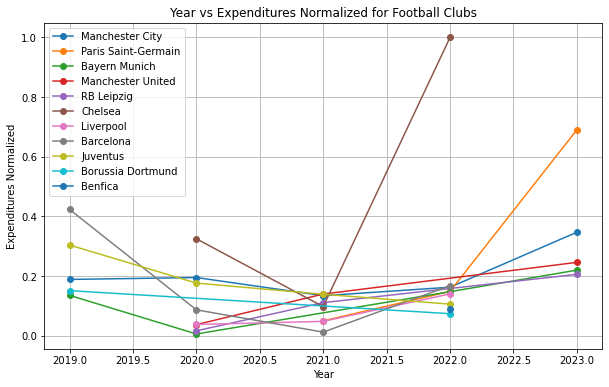

In [ ]:
merged_data = merged_data.dropna(subset=['Expenditures Normalized'])

# Plot the data
plt.figure(figsize=(10, 6))
for club in merged_data['Club'].unique():
    club_data = merged_data[merged_data['Club'] == club]
    plt.plot(club_data['Year'], club_data['Expenditures Normalized'], marker='o', label=club)

plt.xlabel('Year')
plt.ylabel('Expenditures Normalized')
plt.title('Year vs Expenditures Normalized for Football Clubs')
plt.legend()
plt.grid(True)
plt.show()

## **Model: Analysis, Hypothesis Testing, & ML**

During this phase of the Data Lifecycle, we attempt to perform various modeling techniques (such as linear regression or logistic regression) in order to obtain a predictive model of our data. This allows us to predict values for data outside of the scope of our data. For example, we can use a linear regression model to predict how temperature will changein the next few years, which is exactly what we are going to attempt to do below.


In [ ]:
# Convert columns to numeric and drop rows with NaN values
merged_data = merged_data.apply(pd.to_numeric, errors='ignore')

# Drop all rows with any NaN values
merged_clean = merged_data.dropna()

# Preprocessing
# Separate features and target
X = merged_clean.drop('Coefficient', axis=1)
y = merged_clean['Coefficient']

# Preprocessing pipelines for both numeric and categorical data
numeric_features = ['Market Value Normalized', 'Expenditures Normalized', 'SPI Normalized', 'Matches per UCL Normalized',
                    'Wins per UCL Normalized', 'Pts per UCL Normalized', 'Titles per UCL Normalized', 'Winrate Normalized',
                    'Lossrate Normalized', 'GD per game Normalized']

categorical_features = ['Club', 'Year']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print out predictions and actual values
print("\nPredictions vs Actual:")
for pred, actual in zip(y_pred, y_test):
    print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")

Mean Squared Error: 24.514634394984842
R^2 Score: -0.05001493475022478

Predictions vs Actual:
Predicted: 17.57, Actual: 20.00
Predicted: 17.01, Actual: 25.00
Predicted: 24.83, Actual: 33.00
Predicted: 21.73, Actual: 20.00
Predicted: 24.40, Actual: 19.00
Predicted: 22.37, Actual: 21.00
Predicted: 19.04, Actual: 18.00


In [ ]:
# Preprocessing pipelines for both numeric and categorical data
numeric_features = ['Market Value Normalized', 'Expenditures Normalized', 'SPI Normalized', 'Matches per UCL Normalized',
                    'Wins per UCL Normalized', 'Pts per UCL Normalized', 'Titles per UCL Normalized', 'Winrate Normalized',
                    'Lossrate Normalized', 'GD per game Normalized']

categorical_features = ['Club', 'Year']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
gbr = GradientBoostingRegressor(random_state=42)

# Create a pipeline
model_gbr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gbr)
])

# Define parameter grid for GridSearch
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7]
}

# Perform GridSearchCV
grid_search = GridSearchCV(model_gbr, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_gbr_model = grid_search.best_estimator_

# Predict on the test set
y_pred_gbr = best_gbr_model.predict(X_test)

# Evaluate the model
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting Regressor Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting Regressor R^2 Score: {r2_gbr}")

# Print out predictions and actual values
print("\nPredictions vs Actual:")
for pred, actual in zip(y_pred_gbr, y_test):
    print(f"Predicted: {pred:.2f}, Actual: {actual:.2f}")

Gradient Boosting Regressor Mean Squared Error: 24.81369942725451
Gradient Boosting Regressor R^2 Score: -0.0628245384051318

Predictions vs Actual:
Predicted: 21.27, Actual: 20.00
Predicted: 19.38, Actual: 25.00
Predicted: 22.05, Actual: 33.00
Predicted: 19.38, Actual: 20.00
Predicted: 22.96, Actual: 19.00
Predicted: 18.95, Actual: 21.00
Predicted: 18.61, Actual: 18.00


## **Interpretation: Insights Learned**

Insights
Model Performance:

The current model using Gradient Boosting Regressor has an MSE of 24.81 and an R² score of -0.06, indicating that it does not perform well in predicting the coefficients.
The negative R² score suggests that the model is less effective than a simple mean predictor, highlighting the need for further refinement in the modeling approach.
Predictions vs Actual Values:

The predicted values are not closely aligned with the actual values, with significant discrepancies observed in several cases. For instance, a prediction of 22.05 against an actual value of 33.00 indicates a notable error in the model's output.
The inconsistency in predictions underscores the complexity of the factors influencing the coefficients, which may not be fully captured by the current features and model.
Data Quality and Completeness:

The dataset contains several missing values, which were handled by dropping rows with any NaN values. This approach may have led to the loss of potentially valuable data, affecting the model's performance.
The need for better data imputation strategies is evident to ensure that all available information is utilized effectively.
Feature Importance and Engineering:

The existing features, though normalized and theoretically relevant, might not sufficiently capture the nuances of the factors influencing the coefficients.
There is a potential to explore interaction terms, temporal features, and other domain-specific transformations to enhance the model's predictive capability.
Policy Decisions
Data Improvement Initiatives:

Invest in Comprehensive Data Collection: To improve model accuracy, it is essential to collect more complete and detailed data. This includes not only filling gaps in the existing dataset but also gathering additional relevant metrics that may impact club performance and coefficients.
Adopt Advanced Imputation Techniques: Instead of dropping rows with missing values, employ sophisticated imputation methods to retain as much information as possible. Techniques such as K-Nearest Neighbors (KNN) imputation, iterative imputation, or domain-specific imputation strategies should be considered.
Model Refinement and Experimentation:

Explore Advanced Modeling Techniques: Beyond Gradient Boosting, models like XGBoost, LightGBM, Random Forests, and neural networks should be tested to identify a more accurate predictor. Ensemble methods could also be leveraged to combine the strengths of multiple models.
Extensive Hyperparameter Tuning: Conduct a broader and more granular hyperparameter search to optimize the model’s performance. Automated hyperparameter optimization tools such as Bayesian Optimization or Random Search can be utilized for this purpose.
Integration of Domain Knowledge:

Engage with Football Analytics Experts: Collaborate with professionals who have in-depth knowledge of football performance metrics to identify additional features and factors that may be relevant for the model.
Incorporate Historical and Contextual Data: Including historical trends, key events (e.g., major player transfers, changes in management), and contextual factors can provide a richer dataset and potentially improve model predictions.
Strategic Use of Model Insights:

Informed Resource Allocation: While the current model's predictions should not be the sole basis for decisions, they can be used in conjunction with expert opinions to guide resource allocation, such as investments in player acquisitions or training programs.
Enhanced Decision-Making Processes: Develop data-driven strategies that focus on improving specific performance metrics identified by the model. For instance, if certain normalized metrics like SPI Normalized or Pts per UCL Normalized are found to be influential, targeted efforts can be made to enhance these areas.
Ongoing Model Development and Monitoring:

Continuous Improvement Cycle: Establish a cycle of continuous model development and evaluation. Regularly update the model with new data, refine features, and reassess performance to ensure it remains relevant and accurate.
Real-Time Data Integration: Implement systems to integrate real-time data updates, allowing the model to adapt to the latest performance metrics and provide up-to-date predictions.
Conclusion
The current project has provided valuable insights into the factors influencing UEFA Champions League coefficients. However, there is a clear need for further refinement and enhancement of the model to achieve more accurate and reliable predictions. By investing in data quality, exploring advanced modeling techniques, and integrating domain knowledge, we can develop a robust predictive model that offers actionable insights for strategic decision-making in football analytics.
